# Towards a Solution for Improving Customer Data Quality at Triodos Bank
### by Lade Tawak


## Dataset selection

When I started this exploration, I found [this dataset on GitHub](https://github.com/jorritb/dutch-postal-codes/blob/master/postcodes_20190613.csv) which contains over 76000 Dutch addresses and their corresponding postcodes, although it is from 2019.

I later found another [dataset from the Dutch Central Bureau  of Statistics (CBS)](https://www.cbs.nl/nl-nl/maatwerk/2023/35/buurt-wijk-en-gemeente-2023-voor-postcode-huisnummer) which contains all the postcodes and their corresponding cities. It is from 2023 and is the most recent one on their website. This was used for Phase 2 and 3.

# Phase 2

# B. Using CBS Data

A limitation of using the previous dataset is that it is from 2019 and it was only used as an exploration of what could be possible. Furthermore, it has less than 80,000 addresses and based on [data from the CBS](https://www.cbs.nl/nl-nl/maatwerk/2023/35/buurt-wijk-en-gemeente-2023-voor-postcode-huisnummer) there are 7,936,433 possible addresses in the Netherlands (this was gotten from summing up the "AantalAdressen" column)

To continue the exploration, I used the CBS dataset which contains all the postcodes in the netherlands and their corresponding cities. It is the from 2023 and is the most recent one on the site.

This is directly relevant to the main issue identified by the client which is about matching postcodes and cities.


The process looked like
* getting the data
* exploring the data
* experimenting with 5 different models and different parameters for each model (k-NN, Decision Tree, Random Forest, Linear Regression, Naive Bayes)
* evaluating the results of each model based on accuracy etc as well as the values of the client
* using the model to assess user input and suggest corrections
* validating other data
* calculating a score
* wraping everthing in a chatbot

## B1. Preprocessing

To get started, I imported the necessary libraries and loaded the dataset into a Pandas DataFrame. I used ``head()``, ``info()`` to explore the data, understand its structure and content, determine what to do with missing values, and decide what type of cleaning is needed if any

In [ ]:
%pip install seaborn
%pip install scikit-learn
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
addresses = pd.read_csv('PC62023NL.csv')
addresses.head()

GemCode    GemNaam  WijkCode Wijknaam   BuurtCode         Buurtnaam     PC6  \
0  GM0014  Groningen  WK001400  Centrum  BU00140000  Binnenstad-Noord  9711LX   
1  GM0014  Groningen  WK001400  Centrum  BU00140000  Binnenstad-Noord  9712AA   
2  GM0014  Groningen  WK001400  Centrum  BU00140000  Binnenstad-Noord  9712AB   
3  GM0014  Groningen  WK001400  Centrum  BU00140000  Binnenstad-Noord  9712AC   
4  GM0014  Groningen  WK001400  Centrum  BU00140000  Binnenstad-Noord  9712AD   

   AantalAdressen  
0               1  
1               9  
2               6  
3              12  
4              15

In [ ]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493164 entries, 0 to 493163
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   GemCode         493164 non-null  object
 1   GemNaam         493164 non-null  object
 2   WijkCode        493164 non-null  object
 3   Wijknaam        493164 non-null  object
 4   BuurtCode       493164 non-null  object
 5   Buurtnaam       493164 non-null  object
 6   PC6             493164 non-null  object
 7   AantalAdressen  493164 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 30.1+ MB


The dataset contains addresses 493,164 postcodes (the 4 digits and 2 letters) in the Netherlands broken into 8 columns:
- GemCode: The gementee code
- GemNaam: The gementee name
- WijkCode: The area code
- Wijknaam: the name of the area
- BuurtCode: The code of the neighbourhood where the area is locted
- Buurtnaam: The name of the neighbourhood where the area is located
- PC6: The 6 digit postcode
- AantalAdressen: The number of addresses with the postcode in the gemeente

They are all strings values, except for the AantalAdressen which is integers

**The dutch postal code system**

In the Dutch postal code system, the first digit usually represents the province and all 4 digits often represent the city or even a specific neighbourhood. The 2 letters narrow it down to a street name or part of the street. Based on this, I have decided to split the postal code into just the first digits as a new column `PC4` to see if it correlates better than the whole postcode.

The `PC4` is stored as a string because although it is a number, it is not a number in the sense of a mathematical number. It is a string of characters which map to postcodes


In [ ]:
addresses['AantalAdressen'].sum()

np.int64(7936433)

In [ ]:
addresses['PC4'] = addresses['PC6'].str[:4]
addresses

GemCode         GemNaam  WijkCode                      Wijknaam  \
0       GM0014       Groningen  WK001400                       Centrum   
1       GM0014       Groningen  WK001400                       Centrum   
2       GM0014       Groningen  WK001400                       Centrum   
3       GM0014       Groningen  WK001400                       Centrum   
4       GM0014       Groningen  WK001400                       Centrum   
...        ...             ...       ...                           ...   
493159  GM1992  Voorne aan Zee  WK199232                    Zwartewaal   
493160  GM1992  Voorne aan Zee  WK199233  Recreatiestrook Brielse Maas   
493161  GM1992  Voorne aan Zee  WK199233  Recreatiestrook Brielse Maas   
493162  GM1992  Voorne aan Zee  WK199233  Recreatiestrook Brielse Maas   
493163  GM1992  Voorne aan Zee  WK199233  Recreatiestrook Brielse Maas   

         BuurtCode                     Buurtnaam     PC6  AantalAdressen   PC4  
0       BU00140000              Binnenstad-Noord  9711LX               1  9711  
1       BU00140000              Binnenstad-Noord  9712AA               9  9712  
2       BU00140000              Binnenstad-Noord  9712AB               6  9712  
3       BU00140000              Binnenstad-Noord  9712AC              12  9712  
4       BU00140000              Binnenstad-Noord  9712AD              15  9712  
...            ...                           ...     ...             ...   ...  
493159  BU19923209             Verspreide huizen  3238LZ             163  3238  
493160  BU19923300  Recreatiestrook Brielse Maas  3231NA               3  3231  
493161  BU19923300  Recreatiestrook Brielse Maas  3231NC               3  3231  
493162  BU19923300  Recreatiestrook Brielse Maas  3231ND              12  3231  
493163  BU19923300  Recreatiestrook Brielse Maas  3231NE               5  3231  

[493164 rows x 9 columns]

**calculating correlation before dropping rows**. This helps with **feature selection**

In [ ]:
from scipy.stats import chi2_contingency, pearsonr

def calculate_correlation(x, y):
       if pd.api.types.is_numeric_dtype(x) and pd.api.types.is_numeric_dtype(y):
           # use Pearson correlation for categorical colimns
           corr, _ = pearsonr(x, y)
           return corr
       elif pd.api.types.is_categorical_dtype(x) or pd.api.types.is_object_dtype(x) or pd.api.types.is_categorical_dtype(y) or pd.api.types.is_object_dtype(y):
            # use Cramer's V for categorical columns
           confusion_matrix = pd.crosstab(x, y)
           chi2 = chi2_contingency(confusion_matrix)[0]
           n = confusion_matrix.sum().sum()
           phi2 = chi2/n
           r, k = confusion_matrix.shape
           phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
           rcorr = r - ((r-1)**2)/(n-1)
           kcorr = k - ((k-1)**2)/(n-1)
           return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
       else:
           return np.nan

columns = ['GemCode', 'GemNaam', 'WijkCode', 'Wijknaam', 'BuurtCode', 'Buurtnaam', 'PC6', 'PC4', 'AantalAdressen']

# Create an empty correlation matrix
corr_matrix = pd.DataFrame(index=columns, columns=columns)

# Fill the matrix with correlation values
for col1 in columns:
    for col2 in columns:
        corr_matrix.loc[col1, col2] = calculate_correlation(addresses[col1], addresses[col2])

# Display the correlation matrix
print(corr_matrix)

It kept crashing so I took a sample of the data set

In [ ]:
addresses_sample = addresses.sample(frac=0.1, random_state=42)  # Take a 10% sample

In [ ]:
from scipy.stats import chi2_contingency, pearsonr

def calculate_correlation(x, y):
       if pd.api.types.is_numeric_dtype(x) and pd.api.types.is_numeric_dtype(y):
           # use Pearson correlation for categorical colimns
           corr, _ = pearsonr(x, y)
           return corr
       elif pd.api.types.is_categorical_dtype(x) or pd.api.types.is_object_dtype(x) or pd.api.types.is_categorical_dtype(y) or pd.api.types.is_object_dtype(y):
            # use Cramer's V for categorical columns
           confusion_matrix = pd.crosstab(x, y)
           chi2 = chi2_contingency(confusion_matrix)[0]
           n = confusion_matrix.sum().sum()
           phi2 = chi2/n
           r, k = confusion_matrix.shape
           phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
           rcorr = r - ((r-1)**2)/(n-1)
           kcorr = k - ((k-1)**2)/(n-1)
           return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
       else:
           return np.nan

columns = ['GemCode', 'GemNaam', 'WijkCode', 'Wijknaam', 'BuurtCode', 'Buurtnaam', 'PC6', 'PC4', 'AantalAdressen']

# Create an empty correlation matrix
corr_matrix = pd.DataFrame(index=columns, columns=columns)

# Fill the matrix with correlation values
for col1 in columns:
    for col2 in columns:
        corr_matrix.loc[col1, col2] = calculate_correlation(addresses_sample[col1], addresses_sample[col2])

# Display the correlation matrix
print(corr_matrix)

<ipython-input-8-0edc50f801d6>:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(x) or pd.api.types.is_object_dtype(x) or pd.api.types.is_categorical_dtype(y) or pd.api.types.is_object_dtype(y):
<ipython-input-8-0edc50f801d6>:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(x) or pd.api.types.is_object_dtype(x) or pd.api.types.is_categorical_dtype(y) or pd.api.types.is_object_dtype(y):
<ipython-input-8-0edc50f801d6>:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(x) or pd.api.types.is_object_dtype(x) or pd.api.types.is_categorical_dtype(y) or pd.api.types.is_object_dt

                 GemCode   GemNaam  WijkCode  Wijknaam BuurtCode Buurtnaam  \
GemCode              1.0       1.0  0.970835  0.930541  0.880401   0.84644   
GemNaam              1.0       1.0  0.970835  0.930541  0.880401   0.84644   
WijkCode        0.970835  0.970835       1.0   0.99853  0.906849  0.880662   
Wijknaam        0.930541  0.930541   0.99853       1.0  0.905516  0.883052   
BuurtCode       0.880401  0.880401  0.906849  0.905516       1.0  0.989818   
Buurtnaam        0.84644   0.84644  0.880662  0.883052  0.989818       1.0   
PC6             0.083203  0.083203  0.185797  0.181455       0.0       0.0   
PC4             0.964346  0.964346  0.868707  0.867935  0.875785  0.855359   
AantalAdressen       0.0       0.0  0.083758  0.083536  0.170226  0.172818   

                     PC6       PC4 AantalAdressen  
GemCode         0.083203  0.964346            0.0  
GemNaam         0.083203  0.964346            0.0  
WijkCode        0.185797  0.868707       0.083758  
Wijknaam   

Now I want to visualise the correlation scores for easier assessment

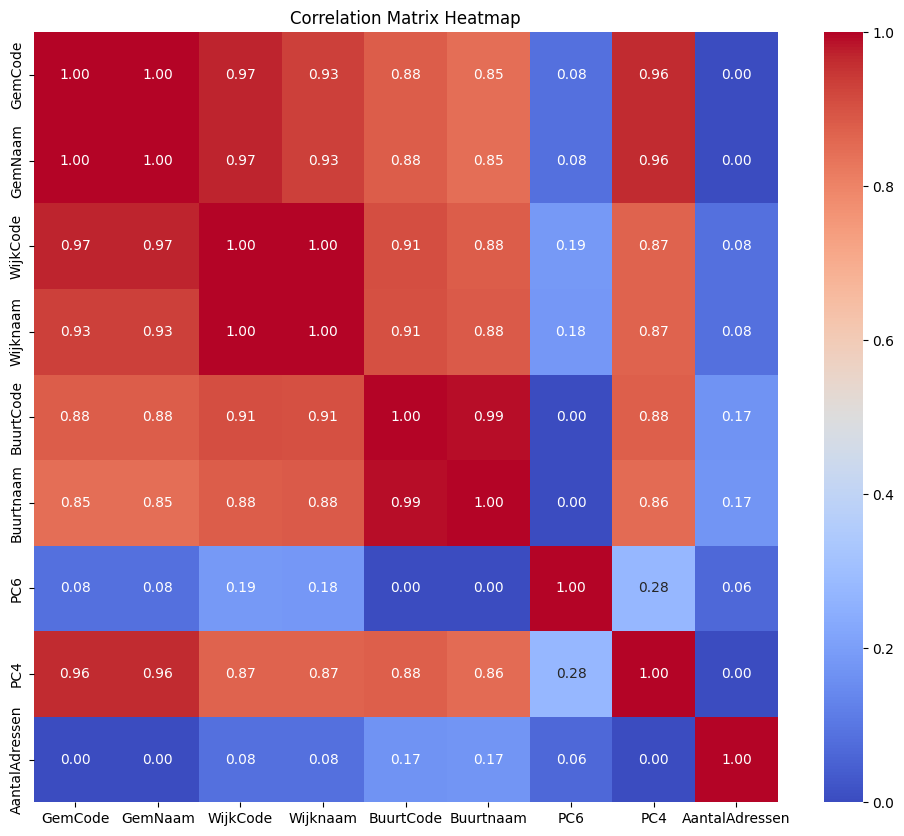

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Convert corr_matrix to numeric
corr_matrix = corr_matrix.apply(pd.to_numeric, errors='coerce')

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


**Correlation evaluation and dropping features**

Surprisingly, PC6 did not correlate with GemNaam. Based on this and based on what features are available in the Triodos dataset, I will drop AantalAdressen and PC6 because they have no and low correlation with GemNaam respectively. I will also drop all the code columns because users don't have this information and they are all highly positively correlated which could create noise.

While creating a machine learning model with only one feature could seem like overkill, as postcodes and municipalities change over time, a trained model can potentially still accurately predict the Gemeente based on the PC4. And since PC6 did not correlate with GemNaam it seems unlikely that it could accurately do the same thing.

Also people don't usually incldue BuurtNaam and the rest in their address so even though they are highly correlated with GemNaam, they are not useful in the model

In [ ]:
addresses_clean = addresses.drop(columns=['AantalAdressen', 'Buurtnaam', 'BuurtCode', 'Wijknaam', 'WijkCode', 'GemCode'])
addresses_clean

GemNaam     PC6   PC4
0            Groningen  9711LX  9711
1            Groningen  9712AA  9712
2            Groningen  9712AB  9712
3            Groningen  9712AC  9712
4            Groningen  9712AD  9712
...                ...     ...   ...
493159  Voorne aan Zee  3238LZ  3238
493160  Voorne aan Zee  3231NA  3231
493161  Voorne aan Zee  3231NC  3231
493162  Voorne aan Zee  3231ND  3231
493163  Voorne aan Zee  3231NE  3231

[493164 rows x 3 columns]

In [ ]:
selected_addresses = addresses_clean.drop(columns=['PC6'])
selected_addresses

GemNaam   PC4
0            Groningen  9711
1            Groningen  9712
2            Groningen  9712
3            Groningen  9712
4            Groningen  9712
...                ...   ...
493159  Voorne aan Zee  3238
493160  Voorne aan Zee  3231
493161  Voorne aan Zee  3231
493162  Voorne aan Zee  3231
493163  Voorne aan Zee  3231

[493164 rows x 2 columns]

There are a number of duplicates so I'll remove them

In [ ]:
selected_addresses = selected_addresses.drop_duplicates(subset=['PC4', 'GemNaam'], keep='first')
selected_addresses

GemNaam   PC4
0            Groningen  9711
1            Groningen  9712
457          Groningen  9713
464          Groningen  9718
514          Groningen  9717
...                ...   ...
492410  Voorne aan Zee  3233
492711  Voorne aan Zee  3231
492795  Voorne aan Zee  3232
492796  Voorne aan Zee  3237
493087  Voorne aan Zee  3238

[4089 rows x 2 columns]

## B2. Building the Models
Because this is a classification problem (it is a categorical variable we are trying to predict), I will explore the following models:
- k-NN
- Decision Tree
- Random Forest
- Linear Regression
- Naive Bayes

### B2.1 k-NN

Now that I have selected the feature for my model, I need to create dummies for the selected feature and then create my X and y variables.
Then split into training and test sets

In [ ]:
selected_addresses = pd.get_dummies(selected_addresses, columns=['PC4'], drop_first=True)
selected_addresses

GemNaam  PC4_1012  PC4_1013  PC4_1014  PC4_1015  PC4_1016  \
0            Groningen     False     False     False     False     False   
1            Groningen     False     False     False     False     False   
457          Groningen     False     False     False     False     False   
464          Groningen     False     False     False     False     False   
514          Groningen     False     False     False     False     False   
...                ...       ...       ...       ...       ...       ...   
492410  Voorne aan Zee     False     False     False     False     False   
492711  Voorne aan Zee     False     False     False     False     False   
492795  Voorne aan Zee     False     False     False     False     False   
492796  Voorne aan Zee     False     False     False     False     False   
493087  Voorne aan Zee     False     False     False     False     False   

        PC4_1017  PC4_1018  PC4_1019  PC4_1021  ...  PC4_9989  PC4_9991  \
0          False     False     False     False  ...     False     False   
1          False     False     False     False  ...     False     False   
457        False     False     False     False  ...     False     False   
464        False     False     False     False  ...     False     False   
514        False     False     False     False  ...     False     False   
...          ...       ...       ...       ...  ...       ...       ...   
492410     False     False     False     False  ...     False     False   
492711     False     False     False     False  ...     False     False   
492795     False     False     False     False  ...     False     False   
492796     False     False     False     False  ...     False     False   
493087     False     False     False     False  ...     False     False   

        PC4_9992  PC4_9993  PC4_9994  PC4_9995  PC4_9996  PC4_9997  PC4_9998  \
0          False     False     False     False     False     False     False   
1          False     False     False     False     False     False     False   
457        False     False     False     False     False     False     False   
464        False     False     False     False     False     False     False   
514        False     False     False     False     False     False     False   
...          ...       ...       ...       ...       ...       ...       ...   
492410     False     False     False     False     False     False     False   
492711     False     False     False     False     False     False     False   
492795     False     False     False     False     False     False     False   
492796     False     False     False     False     False     False     False   
493087     False     False     False     False     False     False     False   

        PC4_9999  
0          False  
1          False  
457        False  
464        False  
514        False  
...          ...  
492410     False  
492711     False  
492795     False  
492796     False  
493087     False  

[4089 rows x 4071 columns]

In [ ]:
X=selected_addresses.drop(columns=['GemNaam'])
y=selected_addresses['GemNaam']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)
pd.DataFrame(X_train).head()

PC4_1012  PC4_1013  PC4_1014  PC4_1015  PC4_1016  PC4_1017  PC4_1018  \
450700     False     False     False     False     False     False     False   
50753      False     False     False     False     False     False     False   
418596     False     False     False     False     False     False     False   
62135      False     False     False     False     False     False     False   
283632     False     False     False     False     False     False     False   

        PC4_1019  PC4_1021  PC4_1022  ...  PC4_9989  PC4_9991  PC4_9992  \
450700     False     False     False  ...     False     False     False   
50753      False     False     False  ...     False     False     False   
418596     False     False     False  ...     False     False     False   
62135      False     False     False  ...     False     False     False   
283632     False     False     False  ...     False     False     False   

        PC4_9993  PC4_9994  PC4_9995  PC4_9996  PC4_9997  PC4_9998  PC4_9999  
450700     False     False     False     False     False     False     False  
50753      False     False     False     False     False     False     False  
418596     False     False     False     False     False     False     False  
62135      False     False     False     False     False     False     False  
283632     False     False     False     False     False     False     False  

[5 rows x 4070 columns]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #train the model

**evaluating accuracy: k-NN**
First, I calculcate the accuracy of the model on the test data.

In [ ]:
knn.score(X_test, y_test)

0.02444987775061125

this is a very poor score
**evaluating precision and recall: k-NN**
but because, there are so many possible classes, I'll jumped straignt to uusing a classification report

In [ ]:
y_test_pred = knn.predict(X_test)
print(classification_report(y_test, y_test_pred))

                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
             Amsterdam       0.02      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Parameter tuning for k-NN**

In [ ]:
from sklearn.metrics import classification_report

for i in range(1,11):
    knn_new = KNeighborsClassifier(n_neighbors = i)
    knn_new = knn_new.fit(X_train, y_train)
    y_test_pred_new = knn_new.predict(X_test)
    print(f"With {i} neighbors the result is:")
    print(classification_report(y_test, y_test_pred_new))


With 1 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 2 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 3 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 4 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 5 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 6 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 7 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 8 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 9 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With 10 neighbors the result is:
                        precision    recall  f1-score   support

         's-Gravenhage       0.00      0.00      0.00        16
      's-Hertogenbosch       0.00      0.00      0.00         8
           Aa en Hunze       0.00      0.00      0.00        11
                Aalten       0.00      0.00      0.00         2
         Achtkarspelen       0.00      0.00      0.00         2
               Alkmaar       0.00      0.00      0.00        11
                Almelo       0.00      0.00      0.00         3
                Almere       0.00      0.00      0.00        13
   Alphen aan den Rijn       0.00      0.00      0.00         5
          Alphen-Chaam       0.00      0.00      0.00         1
                Altena       0.00      0.00      0.00         3
               Ameland       0.00      0.00      0.00         1
            Amersfoort       0.00      0.00      0.00         5
            Amstelveen       0.00      0.00      0.00         1
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Results of k-NN**

Overall, the scores for k-NN are very poor close to 0% accuracy even when different parameters are used

### B2.2 Decision Tree

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(addresses_clean['GemNaam'])


In [ ]:
addresses_encoded = addresses_clean.drop(columns=['PC6']).drop_duplicates(subset=['PC4', 'GemNaam'], keep='first')
# Encode categorical variables
categorical_columns = ['PC4']
for col in categorical_columns:
    label_encoder = LabelEncoder()
    addresses_encoded.loc[:, col] = label_encoder.fit_transform(addresses_encoded[col])

addresses_encoded.head()

GemNaam   PC4
0    Groningen  3897
1    Groningen  3898
457  Groningen  3899
464  Groningen  3904
514  Groningen  3903

In [ ]:
# Define features (X) and target (y)
X = addresses_encoded.drop(columns=['GemNaam'])
y = addresses_encoded['GemNaam']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.tree import plot_tree

dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_classifier.fit(X_train, y_train)

#predict and evaluate the model
y_pred_tree = dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.08149959250203749
                               precision    recall  f1-score   support

                's-Gravenhage       0.00      0.00      0.00        10
             's-Hertogenbosch       0.00      0.00      0.00         8
                  Aa en Hunze       0.00      0.00      0.00        13
                       Aalten       0.00      0.00      0.00         2
                Achtkarspelen       0.00      0.00      0.00         2
                 Alblasserdam       0.00      0.00      0.00         1
                Albrandswaard       0.00      0.00      0.00         2
                      Alkmaar       0.00      0.00      0.00        10
                       Almelo       0.00      0.00      0.00         5
                       Almere       0.00      0.00      0.00        16
          Alphen aan den Rijn       0.00      0.00      0.00         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                       Altena   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Now I'm visualising the tree

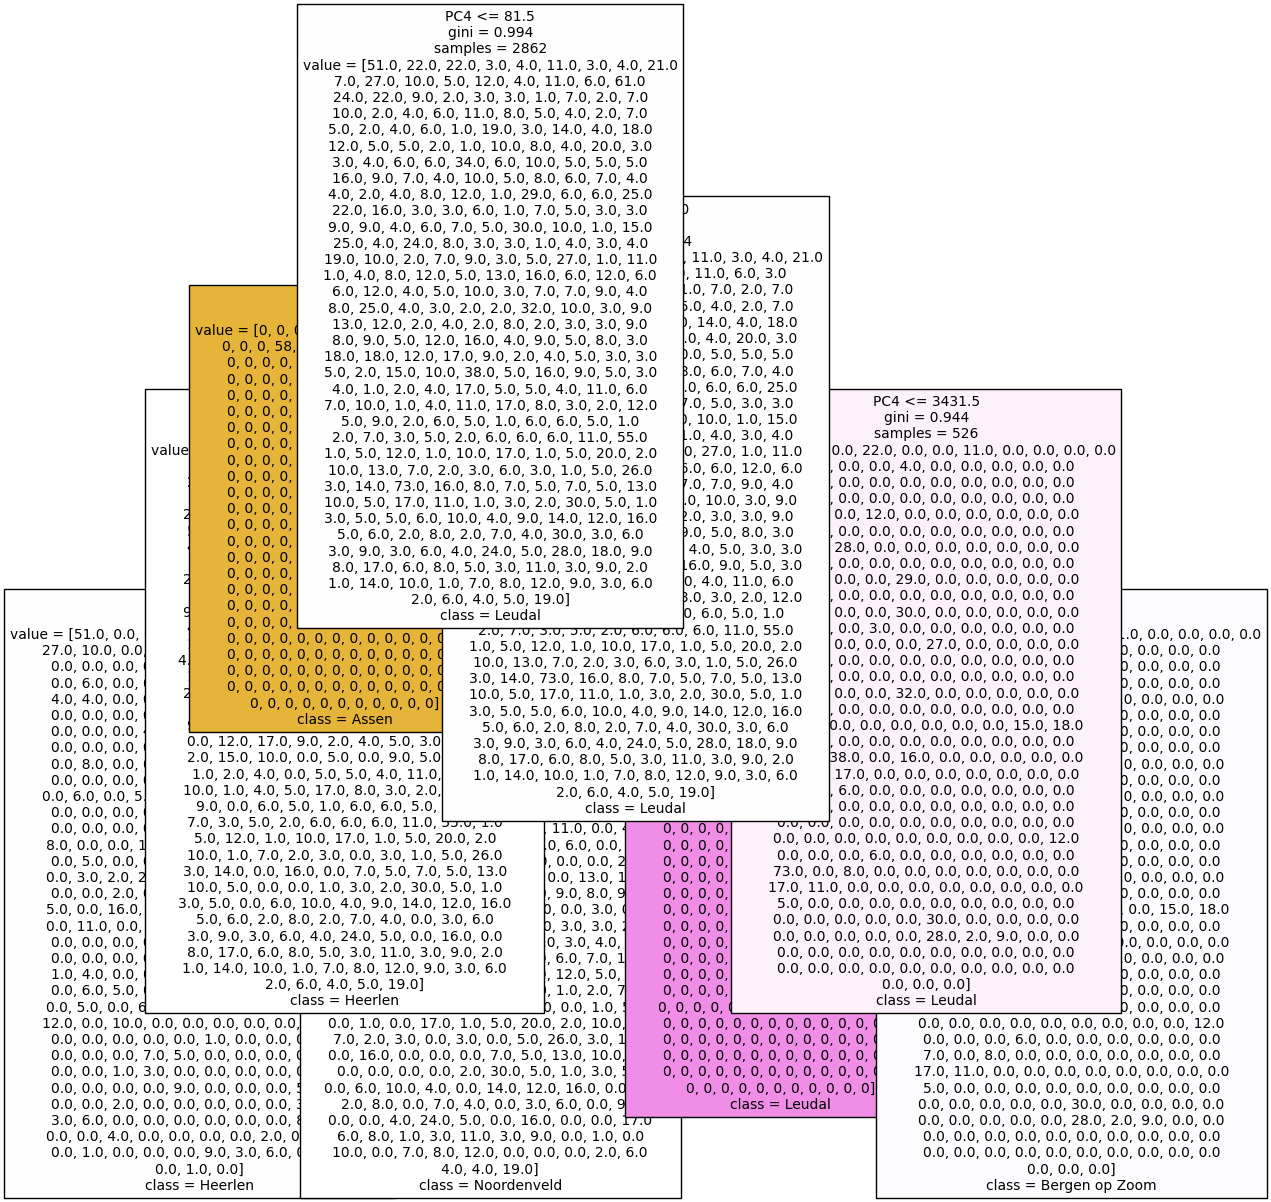

In [ ]:
# Visualize the tree
plt.figure(figsize=(15, 10))

class_names = addresses_encoded['GemNaam'].unique().tolist()

plot_tree(dt_classifier, feature_names=X.columns, class_names=class_names, filled=True, fontsize=10)
plt.show()

Reading the graph:

* **Left branch**: Represents  <= 81.5 (True).
* **Right branch**: Represents  > 81.5 (False).

The model has learned that certain initial postcode digits are strong indicators of which city an address is located in.

### B2.2.1 Decision Tree Hyperparemeter Tuning

To optimize the mode, I will use GridSearchCV to **find the best hyperparameters**

In [ ]:
# Decision Tree Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_tree.best_score_)

# Evaluate on the test set
best_tree = grid_search_tree.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)
print("Test Accuracy of Tuned Decision Tree:", accuracy_score(y_test, y_pred_best_tree))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validated Accuracy: 0.8252969951083159
Test Accuracy of Tuned Decision Tree: 0.7929910350448248


I ran the model again, using the recommended parameters from the grid search

In [ ]:
best_dt_classifier = DecisionTreeClassifier(random_state=42,
                                          max_depth=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2)

best_dt_classifier.fit(X_train, y_train)

best_y_pred_tree = best_dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, best_y_pred_tree))
print(classification_report(y_test, best_y_pred_tree))

Decision Tree Accuracy: 0.7929910350448248
                               precision    recall  f1-score   support

                's-Gravenhage       0.83      1.00      0.91        10
             's-Hertogenbosch       1.00      0.88      0.93         8
                  Aa en Hunze       0.81      1.00      0.90        13
                       Aalten       1.00      1.00      1.00         2
                Achtkarspelen       0.33      0.50      0.40         2
                 Alblasserdam       1.00      1.00      1.00         1
                Albrandswaard       1.00      1.00      1.00         2
                      Alkmaar       0.83      1.00      0.91        10
                       Almelo       0.57      0.80      0.67         5
                       Almere       1.00      1.00      1.00        16
          Alphen aan den Rijn       0.57      0.67      0.62         6
                 Alphen-Chaam       0.50      1.00      0.67         1
                       Altena    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

and then visualised it

[codecarbon INFO @ 00:10:32] Energy consumed for RAM : 0.008544 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:10:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:32] Energy consumed for All CPU : 0.009558 kWh
[codecarbon INFO @ 00:10:32] Energy consumed for all GPUs : 0.009947 kWh. Total GPU Power : 44.450512682822755 W
[codecarbon INFO @ 00:10:32] 0.028050 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:10:47] Energy consumed for RAM : 0.008702 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:10:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:10:47] Energy consumed for All CPU : 0.009735 kWh
[codecarbon INFO @ 00:10:47] Energy consumed for all GPUs : 0.010131 kWh. Total GPU Power : 44.15424403464929 W
[codecarbon INFO @ 00:10:47] 0.028569 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:11:02] Energy consumed for RAM : 0.008861 kWh. RAM Power : 

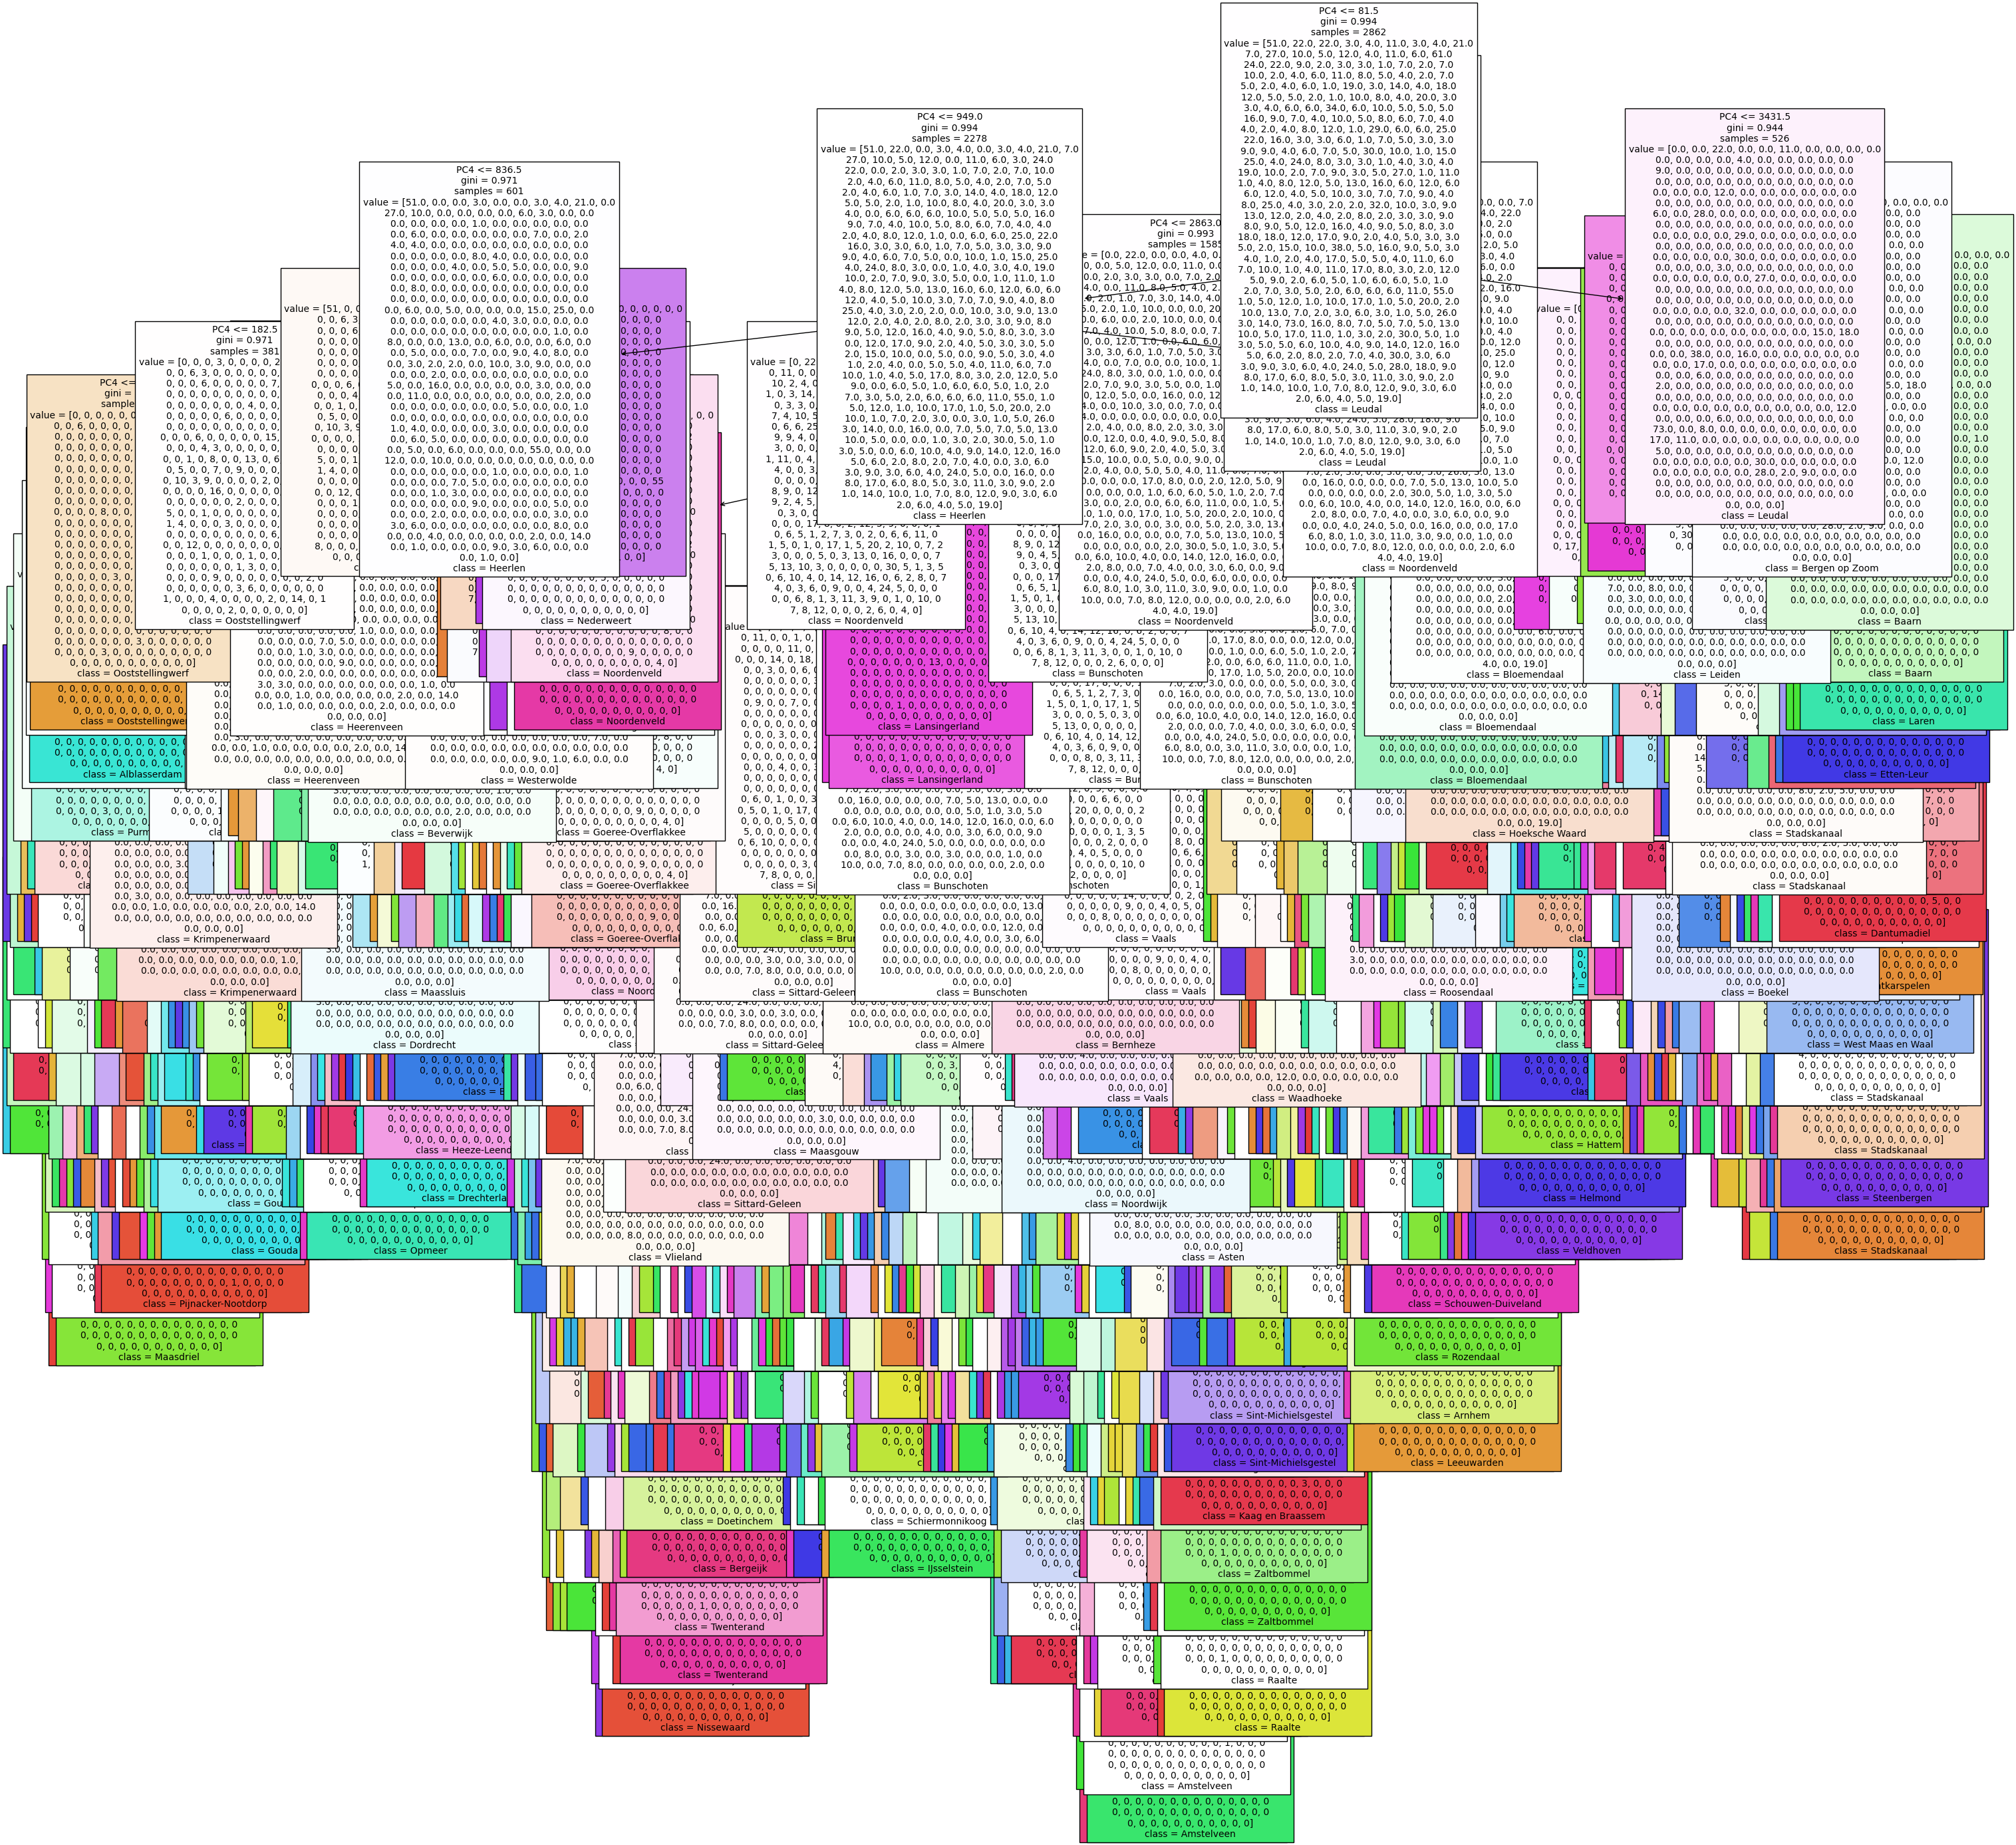

In [ ]:
# Visualize new decision tree
plt.figure(figsize=(35, 30))

class_names = addresses_encoded['GemNaam'].unique().tolist()

plot_tree(best_dt_classifier, feature_names=X.columns, class_names=class_names, filled=True, fontsize=10)
plt.show()

As you can see, this is a very complex decision tree that is very difficult to read and interpret. So, I wanted to see if I could make it simpler. To do this, I first checked the depth of the decision tree to see how many Nodes were actually used

In [ ]:
best_tree_depth = best_dt_classifier.get_depth()
print(f"The depth of the decision tree is: {best_tree_depth}")

The depth of the decision tree is: 28


After calculating the depth, I **iterated** with a lower number for max depth and also increased the `min_samples_split` and `min_samples_leaf` to **reduce the risk of overfitting**

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42,
                                          max_depth=20,
                                          min_samples_split=4,
                                          min_samples_leaf=3)

dt_model.fit(X_train, y_train)

new_y_pred_tree = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, new_y_pred_tree))
print(classification_report(y_test, new_y_pred_tree))

Decision Tree Accuracy: 0.7440912795436023
                               precision    recall  f1-score   support

                's-Gravenhage       0.83      1.00      0.91        10
             's-Hertogenbosch       0.88      0.88      0.88         8
                  Aa en Hunze       0.80      0.92      0.86        13
                       Aalten       0.40      1.00      0.57         2
                Achtkarspelen       0.20      0.50      0.29         2
                 Alblasserdam       0.50      1.00      0.67         1
                Albrandswaard       1.00      1.00      1.00         2
                      Alkmaar       0.67      1.00      0.80        10
                       Almelo       1.00      0.80      0.89         5
                       Almere       1.00      1.00      1.00        16
          Alphen aan den Rijn       0.57      0.67      0.62         6
                 Alphen-Chaam       0.50      1.00      0.67         1
                       Altena    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

 When
 - `max_depth = 16`, accuracy = 65.85%

                     accuracy                           0.66    1227
                    macro avg       0.44      0.49      0.44    1227
                 weighted avg       0.63      0.66      0.62    1227

- `max_depth = 20`, accuracy = 74.41%

                     accuracy                           0.74      1227
                    macro avg       0.57      0.61      0.57      1227
                 weighted avg       0.74      0.74      0.73      1227

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(new_dt_classifier, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.64792176 0.79462103 0.75550122 0.77628362 0.61933905]
Average cross-validation score: 0.7187333347298992


When max_depth is 20, the training accuracy (74%) is slightly higher than the average cross-validation accuracy (72%). It's a small difference which does not suggest high overfitting.

In [ ]:
new_dt_classifier = DecisionTreeClassifier(random_state=42,
                                          max_depth=16,
                                          min_samples_split=4,
                                          min_samples_leaf=3)

new_dt_classifier.fit(X_train, y_train)

new_y_pred_tree = new_dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, new_y_pred_tree))
print(classification_report(y_test, new_y_pred_tree))

Decision Tree Accuracy: 0.658516707416463
                               precision    recall  f1-score   support

                's-Gravenhage       0.83      1.00      0.91        10
             's-Hertogenbosch       0.53      1.00      0.70         8
                  Aa en Hunze       0.80      0.92      0.86        13
                       Aalten       0.40      1.00      0.57         2
                Achtkarspelen       0.20      0.50      0.29         2
                 Alblasserdam       0.50      1.00      0.67         1
                Albrandswaard       1.00      1.00      1.00         2
                      Alkmaar       0.67      1.00      0.80        10
                       Almelo       0.45      1.00      0.62         5
                       Almere       1.00      1.00      1.00        16
          Alphen aan den Rijn       0.57      0.67      0.62         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                       Altena     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(new_dt_classifier, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.54889976 0.67726161 0.61491443 0.66503667 0.52876377]
Average cross-validation score: 0.6069752478654988


When `max_depth` is 16, there seems to now be an underfitting problem, as the average cross valdiation accuracy is a little over 5% lower which is larger than the gap with 20 in the opposite direction

In [ ]:
new_dt_classifier = DecisionTreeClassifier(random_state=42,
                                          max_depth=18,
                                          min_samples_split=4,
                                          min_samples_leaf=3)

new_dt_classifier.fit(X_train, y_train)

new_y_pred_tree = new_dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, new_y_pred_tree))
print(classification_report(y_test, new_y_pred_tree))

Decision Tree Accuracy: 0.706601466992665
                               precision    recall  f1-score   support

                's-Gravenhage       0.83      1.00      0.91        10
             's-Hertogenbosch       0.88      0.88      0.88         8
                  Aa en Hunze       0.80      0.92      0.86        13
                       Aalten       0.40      1.00      0.57         2
                Achtkarspelen       0.20      0.50      0.29         2
                 Alblasserdam       0.50      1.00      0.67         1
                Albrandswaard       1.00      1.00      1.00         2
                      Alkmaar       0.67      1.00      0.80        10
                       Almelo       1.00      0.80      0.89         5
                       Almere       1.00      1.00      1.00        16
          Alphen aan den Rijn       0.57      0.67      0.62         6
                 Alphen-Chaam       0.50      1.00      0.67         1
                       Altena     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(new_dt_classifier, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.61124694 0.74938875 0.70660147 0.71638142 0.58261934]
Average cross-validation score: 0.6732475841904756


An accuracy score of 70.66% and average crossvalidation score of 67.32%. There is a bigger drop in accuracy from when the max_depth is 20, so I'll leave the best at 20.

### B2.3 Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model's performance
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, rf_predictions))


Random Forest Accuracy: 79.38%
Classification Report:
                                precision    recall  f1-score   support

                's-Gravenhage       0.83      1.00      0.91        10
             's-Hertogenbosch       1.00      0.88      0.93         8
                  Aa en Hunze       0.81      1.00      0.90        13
                       Aalten       1.00      1.00      1.00         2
                Achtkarspelen       0.33      0.50      0.40         2
                 Alblasserdam       1.00      1.00      1.00         1
                Albrandswaard       1.00      1.00      1.00         2
                      Alkmaar       0.83      1.00      0.91        10
                       Almelo       0.57      0.80      0.67         5
                       Almere       1.00      1.00      1.00        16
          Alphen aan den Rijn       0.57      0.67      0.62         6
                 Alphen-Chaam       0.50      1.00      0.67         1
                     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

accuracy is 79.38% now I want to cross validate to check for overfitting

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5)
print("Average cross-validation score:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average cross-validation score: 0.7605599830017986


**Random Forest Model Results**

The test accuracy is slightly higher than  the cross-validation score which suggests that the model is probably not overfitting significantly. The difference between the two scores is approximately 3%, a small number indicating a relatively stable model performance

### B2.4 Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
log_reg_model.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg_model.predict(X_test)

# Evaluate the model's performance
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, log_reg_predictions))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 8.31%
Classification Report:
                                precision    recall  f1-score   support

                's-Gravenhage       0.00      0.00      0.00        10
             's-Hertogenbosch       0.00      0.00      0.00         8
                  Aa en Hunze       0.00      0.00      0.00        13
                       Aalten       0.00      0.00      0.00         2
                Achtkarspelen       0.00      0.00      0.00         2
                 Alblasserdam       0.00      0.00      0.00         1
                Albrandswaard       0.00      0.00      0.00         2
                      Alkmaar       0.00      0.00      0.00        10
                       Almelo       0.00      0.00      0.00         5
                       Almere       0.79      0.94      0.86        16
          Alphen aan den Rijn       0.00      0.00      0.00         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The score of 8.31 is so poor, I'll change the parameter for multi_class to test it out although I don't think there'll be any improvement

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
log_reg_model.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg_model.predict(X_test)

# Evaluate the model's performance
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, log_reg_predictions))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 5.62%
Classification Report:
                                precision    recall  f1-score   support

                's-Gravenhage       0.00      0.00      0.00        10
             's-Hertogenbosch       0.00      0.00      0.00         8
                  Aa en Hunze       0.00      0.00      0.00        13
                       Aalten       0.00      0.00      0.00         2
                Achtkarspelen       0.00      0.00      0.00         2
                 Alblasserdam       0.00      0.00      0.00         1
                Albrandswaard       0.00      0.00      0.00         2
                      Alkmaar       0.00      0.00      0.00        10
                       Almelo       0.00      0.00      0.00         5
                       Almere       0.00      0.00      0.00        16
          Alphen aan den Rijn       0.00      0.00      0.00         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

The score of 5.6% is even worse so this is not a contender. Finally, I'll test out Naive Bayes

### B2.5 Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
nb_predictions = nb_model.predict(X_test)

# Evaluate the model's performance
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 1.96%
Classification Report:
                                precision    recall  f1-score   support

                's-Gravenhage       0.00      0.00      0.00        10
             's-Hertogenbosch       0.00      0.00      0.00         8
                  Aa en Hunze       0.00      0.00      0.00        13
                       Aalten       0.00      0.00      0.00         2
                Achtkarspelen       0.00      0.00      0.00         2
                 Alblasserdam       0.00      0.00      0.00         1
                Albrandswaard       0.00      0.00      0.00         2
                      Alkmaar       0.00      0.00      0.00        10
                       Almelo       0.00      0.00      0.00         5
                       Almere       0.00      0.00      0.00        16
          Alphen aan den Rijn       0.00      0.00      0.00         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                       A

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The score of 1.96 is very poor. Nonetheless, I will try to **tune the hyperparameters to see the best option**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Create a GridSearchCV object
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Create a Multinomial Naive Bayes classifier with the best hyperparameters
nb_classifier = MultinomialNB(alpha=best_alpha)

# Train the classifier
nb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


MultinomialNB(alpha=0.1)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Naive Bayes model
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)

# Predict on the test set
nb_predictions = nb_model.predict(X_test)

# Evaluate the model's performance
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 1.96%
Classification Report:
                                precision    recall  f1-score   support

                's-Gravenhage       0.00      0.00      0.00        10
             's-Hertogenbosch       0.00      0.00      0.00         8
                  Aa en Hunze       0.00      0.00      0.00        13
                       Aalten       0.00      0.00      0.00         2
                Achtkarspelen       0.00      0.00      0.00         2
                 Alblasserdam       0.00      0.00      0.00         1
                Albrandswaard       0.00      0.00      0.00         2
                      Alkmaar       0.00      0.00      0.00        10
                       Almelo       0.00      0.00      0.00         5
                       Almere       0.00      0.00      0.00        16
          Alphen aan den Rijn       0.00      0.00      0.00         6
                 Alphen-Chaam       0.00      0.00      0.00         1
                       A

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Even with hyperparameter tuning, the score is still very low so there's no need to continue with Naive Bayes

## B3. Conclusions on experimenting with various models for the CBS data
The best performing models were the decision tree and the random forest classifier

**decision tree**

Based on the different max depths that were explored and the resulting accuracy and cross validation scores, it seems that the best `max_depth` is 20 because it has the highest accuracy with the lowest difference in avg crossvalidation accuracy which suggests that it is at the least risk of over fitting or udnerfitting. It also has the highest precision and recall scores.

                     accuracy                           0.74      1227
                    macro avg       0.57      0.61      0.57      1227
                 weighted avg       0.74      0.74      0.73      1227

**random forest classifier**

Also had a good accuracy score of 79.38% and there was also only a small difference with the cross validation average.

                     accuracy                           0.79      1227
                    macro avg       0.70      0.69      0.67      1227
                 weighted avg       0.83      0.79      0.79      1227


Although the random classifer has slightly higher accuracy and other metrics, the decision tree performs relatively well and is a much simpler model, requiring less compute and energy. This is closely aligned with Triodos's goal. Though it seems small on a small scale, if it is used long term and deployed to other address systems in other countries and to larger data sets, these compute and energy costs add up over time.

But to get actual numbers, I will **use codecarbon to calculate** the actual time it takes to run, how much energy is consumed, and how much emissions are made.

In [ ]:
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.4/576.4 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take in

In [ ]:
from codecarbon import EmissionsTracker

def train_and_track_emissions(X_train, y_train):
    tracker = EmissionsTracker(
        project_name="postcode-city-model",
        allow_multiple_runs=True
    )
    tracker.start()

    from sklearn.ensemble import RandomForestClassifier

    # Create and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    total_co2_kg = tracker.stop()
    details = tracker.final_emissions_data

    emissions_dict = {
        'duration': details.duration,
        'energy_consumed': details.energy_consumed,
        'emissions': total_co2_kg
    }

    return rf_model, emissions_dict


In [ ]:
# Train and track
rf_model, emissions = train_and_track_emissions(X_train, y_train)

# Print emissions
print(f"Duration:        {emissions['duration']:.1f} s")
print(f"Energy:          {emissions['energy_consumed']:.6f} kWh")
print(f"CO₂e:            {emissions['emissions']:.6f} kg")


[codecarbon WARNING @ 00:25:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:25:19] [setup] RAM Tracking...
[codecarbon INFO @ 00:25:19] [setup] CPU Tracking...
[codecarbon WARNING @ 00:25:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:25:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:25:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 00:25:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:25:20] [setup] GPU Tracking...
[codecarbon INFO @ 00:25:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:25:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Duration:        2.1 s
Energy:          0.000074 kWh
CO₂e:            0.000035 kg


Doing the same for decision tree

In [ ]:
from codecarbon import EmissionsTracker

def train_dt_and_track_emissions(X_train, y_train):
    tracker = EmissionsTracker(
        project_name="decision-tree-postcode-city-model",
        allow_multiple_runs=True
    )
    tracker.start()

    from sklearn.ensemble import RandomForestClassifier

    # Create and train the Random Forest model
    from sklearn.tree import DecisionTreeClassifier
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_split=4, min_samples_leaf=3)
    dt_model.fit(X_train, y_train)

    total_co2_kg = tracker.stop()
    details = tracker.final_emissions_data

    emissions_dict = {
        'duration': details.duration,
        'energy_consumed': details.energy_consumed,
        'emissions': total_co2_kg
    }

    return dt_model, emissions_dict


In [ ]:
dt_model, dt_emissions = train_dt_and_track_emissions(X_train, y_train)
print(f"DT Duration: {dt_emissions['duration']:.1f} s")
print(f"DT Energy:   {dt_emissions['energy_consumed']:.6f} kWh")
print(f"DT CO₂e:     {dt_emissions['emissions']:.6f} kg")

[codecarbon WARNING @ 00:29:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:29:11] [setup] RAM Tracking...
[codecarbon INFO @ 00:29:11] [setup] CPU Tracking...
[codecarbon INFO @ 00:29:12] Energy consumed for RAM : 0.003482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:29:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:12] Energy consumed for All CPU : 0.003895 kWh
[codecarbon INFO @ 00:29:12] Energy consumed for all GPUs : 0.004046 kWh. Total GPU Power : 44.22396522792088 W
[codecarbon INFO @ 00:29:12] 0.011424 kWh of electricity used since the beginning.
[codecarbon WARNING @ 00:29:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:29:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem t

DT Duration: 0.0 s
DT Energy:   0.000001 kWh
DT CO₂e:     0.000000 kg


**Results of codecarbon assessment**


| Model         | Accuracy (%) | Duration (s) | Energy (kWh) | CO₂e (kg) |
| ------------- | ------------ | ------------ | ------------ | --------- |
| Decision Tree | 74  | 0.0          | 0.000001     | 0.000000  |
| Random Forest | 79        | 2.1          | 0.000074     | 0.000035  |




I will visualise the results for better comparison

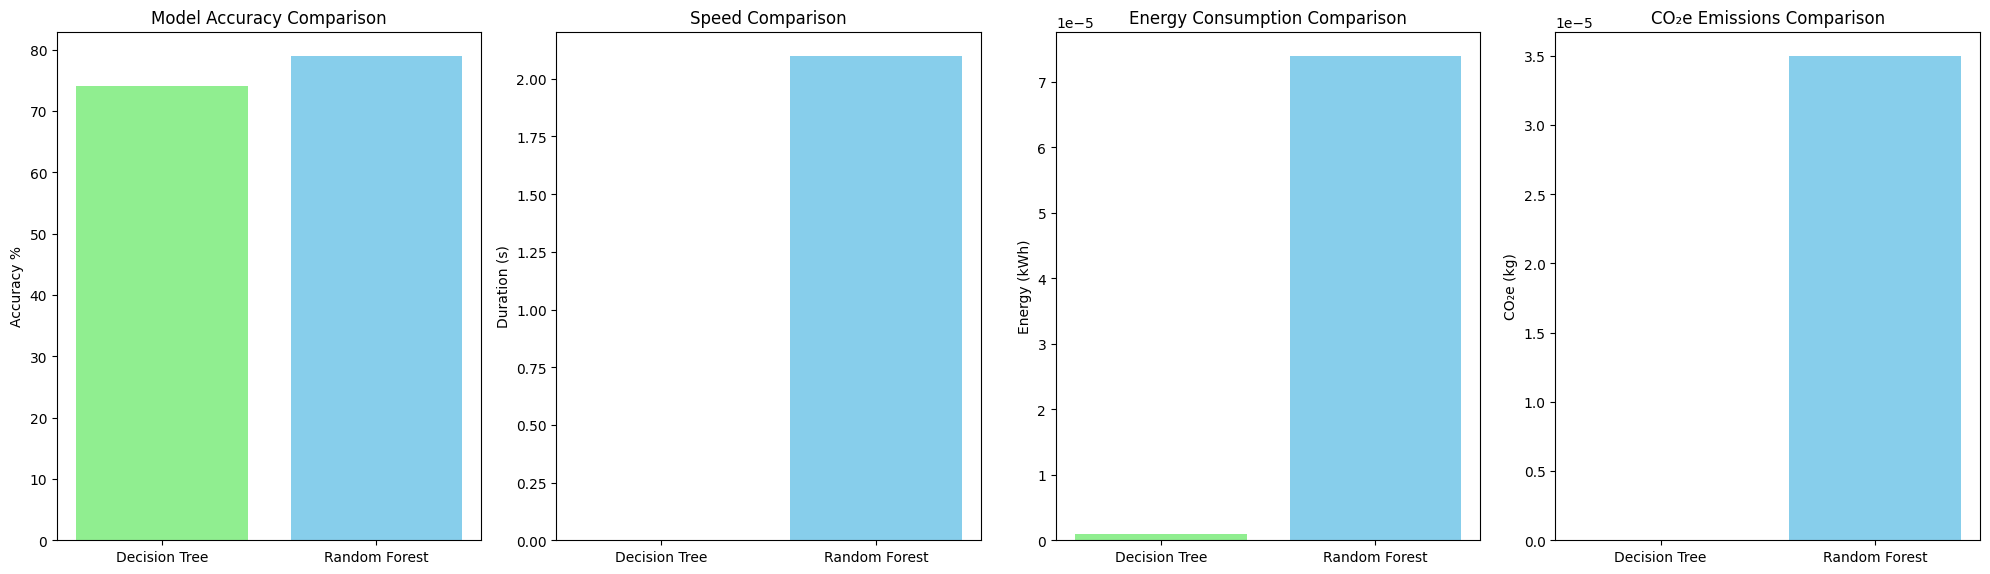

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


model_names = ['Decision Tree', 'Random Forest']
accuracy = [74, 79]
duration = [0.0, 2.1]
energy_consumed = [0.000001, 0.000074]
emissions = [0.000000, 0.000035]

data = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracy,
    'Duration (s)': duration,
    'Energy (kWh)': energy_consumed,
    'CO₂e (kg)': emissions
})

x = range(len(model_names))

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

# Plot Accuracy
axes[0].bar(x, data['Accuracy (%)'], color=['lightgreen', 'skyblue'])
axes[0].set_ylabel('Accuracy %')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(data['Model'])

# Plot Duration
axes[1].bar(x, data['Duration (s)'], color=['lightgreen', 'skyblue'])
axes[1].set_ylabel('Duration (s)')
axes[1].set_title('Speed Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(data['Model'])

# Plot Energy Consumed
axes[2].bar(x, data['Energy (kWh)'], color=['lightgreen', 'skyblue'])
axes[2].set_ylabel('Energy (kWh)')
axes[2].set_title('Energy Consumption Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(data['Model'])

# Plot CO2e Emissions
axes[3].bar(x, data['CO₂e (kg)'], color=['lightgreen', 'skyblue'])
axes[3].set_ylabel('CO₂e (kg)')
axes[3].set_title('CO₂e Emissions Comparison')
axes[3].set_xticks(x)
axes[3].set_xticklabels(data['Model'])


# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

As we can see from this visualisation, the difference appears clearer

Given the closeness in the accuracy scores of the two models, although Decision Tree has slightly lower accuracy, it is better on the other values of sustainability (has less emissions and less energy consumption), efficiency (is faster), and simplicity and transparency (is easier to explain)

## B4. Collecting user input and giving feedback

Now I have to check how the system would work ot identify post code issues.

To do that I have imported the model and encoder and created functions to check whether the postcode and city match and what the correct one could possibly be if it's incorrect)

In [ ]:
import re
import joblib

# Save the Decision Tree model
joblib.dump(dt_model, "dt_model.joblib")

# Save the Label Encoder
joblib.dump(label_encoder, "label_encoder.joblib")

dt_model = joblib.load("dt_model.joblib")
label_encoder = joblib.load("label_encoder.joblib")

In [ ]:
def featurize_pc4(postcode: str) -> pd.DataFrame:
    m = re.match(r"^\s*(\d{4})", postcode)
    if not m:
      raise ValueError(f"Invalid postcode format: {postcode!r}")
    pc4 = m.group(1)
    pc4_num = label_encoder.transform([pc4])[0]
    return pd.DataFrame({"PC4": [pc4_num]})

def check_and_suggest_city(postcode: str, user_city: str):
    Xnew = featurize_pc4(postcode)
    pred_city = dt_model.predict(Xnew)[0]
    if pred_city.lower() == user_city.strip().lower():
      return True, pred_city
    return False, pred_city

def suggest_top_k(postcode: str, threshold: float = 0.85):
    Xnew = featurize_pc4(postcode)
    probs = dt_model.predict_proba(Xnew)[0]
    cities = dt_model.classes_

    #top candidate
    idx = probs.argmax()
    top_conf = probs[idx]
    top_city = cities[idx]

    #suggest only if confidence > threshold
    if top_conf >= threshold:
      return top_city, top_conf
    else:
      return None, None

In [ ]:
#testing
postcode = "1011AB"
user_city = "Rotterdam"

match, suggestion = check_and_suggest_city(postcode, user_city)
if match:
    print(f"'{user_city}' is correct for {postcode}.")
else:
    city, conf = suggest_top_k(postcode, threshold=0.85)
    if city:
        print(f"'{user_city}' doesn’t seem right for {postcode}. Do you mean '{city}'?")
    else:
        print("Please check that your have the right city and postcode.")

'Rotterdam' doesn’t seem right for 1011AB. Do you mean 'Amsterdam'?


## B5. Checking for other personal data

Now that I have selected a model for checking address data, I want to check for email and phone number validity.

I want to check if the email follows a valid email pattern, I also want to see if the phone number is a valid phone number and also see if it matches the country pattern. Thre are existing libraries that make this possible, so I'll use those.

To keep it simple and sustainable (as defined by the stakeholder values), I'll use these existing libraries instead of generating synthetic data to use for anomaly detection of phone numbers and emails.

In [ ]:
#testing the function
tests = [
    ("jip@example.com", "+1 650-253-0000", "US"),
    ("janeke@@example..com",    "01234 5678",  "GB"),
    ("jipjanek@mail.org",       "+31612345678", "NL"),
    ("femke@mail",            "+49 151 2345 6789", "DE"),
]

for email, phone, region in tests:
    print(f"---\nEmail:  {email:20}  valid? {is_valid_email(email)}")
    print(f"Phone:  {phone:20}  valid? {is_valid_phone(phone, region)}")


---
Email:  jip@example.com       valid? True
Phone:  +1 650-253-0000       valid? True
---
Email:  janeke@@example..com  valid? False
Phone:  01234 5678            valid? False
---
Email:  jipjanek@mail.org     valid? True
Phone:  +31612345678          valid? True
---
Email:  femke@mail            valid? False
Phone:  +49 151 2345 6789     valid? True


In [ ]:
!pip install phonenumbers

import re
import phonenumbers
from phonenumbers.phonenumberutil import NumberParseException

#validate emails
email_regex = re.compile(
    r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
)

def is_valid_email(email: str) -> bool:
    return bool(email_regex.match(email))


#validate phone number
def is_valid_phone(number: str, region: str = None) -> bool:
    try:
        parsed = phonenumbers.parse(number, region)
        # Check if it's a possible number and actually valid
        return phonenumbers.is_valid_number(parsed)
    except NumberParseException:
        return False


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.7 MB/s eta 0:00:00


## B6. Putting it all together

Now that I have the different parts of the personal data validation, I can calculate the completeness, correctness, and currency scores.

In [ ]:
REQUIRED_FIELDS = [
    'first_name', 'last_name', 'email', 'phone_number',
    'street', 'postcode', 'city']

In [ ]:
def calculate_completeness(row):
    missing = [f for f in REQUIRED_FIELDS
               if pd.isna(row.get(f)) or str(row.get(f)).strip()==""]
    completeness = 1 - len(missing)/len(REQUIRED_FIELDS)
    issues = [f"Missing {f.replace('_',' ')}" for f in missing]
    return completeness, issues

In [ ]:
def calculate_correctness(row):
    issues = []
    score = 0
    # postcode and city match
    if isinstance(row['postcode'], str) and isinstance(row['city'], str):
        ok, suggestion = check_and_suggest_city(row['postcode'], row['city'])
        if ok:
            score += 1
        else:
            cand, conf = suggest_top_k(row['postcode'], threshold=0.85)
            if cand:
                issues.append(f"Postcode–city mismatch: did you mean “{cand}”?")
            else:
                issues.append("Postcode–city don’t match")
    else:
        issues.append("Postcode or city missing or invalid")

    # email
    if is_valid_email(row.get('email', "")):
        score += 1
    else:
        issues.append("Invalid email address")

    #phone
    if is_valid_phone(row.get('phone_number', ""), region=None):
        score += 1
    else:
        issues.append("Invalid phone number")

    correctness = score / 3
    return correctness, issues

I want the Currency score to decay over time as the data is no longer current as time passes.
  

In [ ]:
def calculate_currency(row,
                       full_decay_days: int = 365):
    issues = []
    try:
        created = pd.to_datetime(row['account_creation_date'])
        now     = pd.Timestamp.now()
        age     = (now - created).days

        # Compute linear decay
        frac    = age / full_decay_days
        score   = max(0.0, 1.0 - frac)


        if age >= full_decay_days:
            issues.append(f"Account older than {full_decay_days//30} months; data is stale.")
    except Exception:
        score = 0.0
        issues.append("Invalid or missing account creation date")

    return score, issues


In [ ]:
def calculate_data_quality_score(row):
    comp, comp_issues = calculate_completeness(row)
    corr, corr_issues = calculate_correctness(row)
    curr, curr_issues = calculate_currency(row, full_decay_days=365)

    overall = 0.4*comp + 0.4*corr + 0.2*curr
    overall_pct = round(overall*100, 1)

    explanation = comp_issues + corr_issues + curr_issues
    if not explanation:
        explanation = ["Your data appears up to date!"]

    return {
        'score': overall_pct,
        'subscores': {
            'completeness': round(comp*100,1),
            'correctness':  round(corr*100,1),
            'currency':     round(curr*100,1)
        },
        'issues': explanation
    }


## B7. Putting it into a chatbot

In [ ]:
!pip install -qU "langchain[groq]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/437.6 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.0 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/127.5 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 12.3 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.schema import SystemMessage, HumanMessage

# Initialize chatbot
chat_model = ChatGroq(
    model_name="llama3-8b-8192",
    temperature=0,
    groq_api_key=" ")

In [ ]:
import json, re, joblib, pandas as pd, phonenumbers
from phonenumbers.phonenumberutil import NumberParseException


# Load trained model
dt_model      = joblib.load("dt_model.joblib")
pc4_encoder   = joblib.load("label_encoder.joblib")

# validators & featurizer
email_regex = re.compile(r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$")
def is_valid_email(email):
    return bool(email_regex.match(email))

def is_valid_phone(num, region=None):
    try:
        p = phonenumbers.parse(num, region)
        return phonenumbers.is_valid_number(phone)
    except NumberParseException:
        return False

def featurize_pc4(pc):
    m = re.match(r"^\s*(\d{4})", pc)
    if not m: raise ValueError("Invalid postcode")
    return pc4_encoder.transform([m.group(1)])[0]

def check_and_suggest_city(pc, city):
    X = pd.DataFrame({"PC4":[featurize_pc4(pc)]})
    pred = dt_model.predict(X)[0]
    ok   = (pred.lower() == city.strip().lower())
    return ok, pred

def suggest_top_k(pc, threshold=0.7):
    X     = pd.DataFrame({"PC4":[featurize_pc4(pc)]})
    probs = dt_model.predict_proba(X)[0]
    idx   = probs.argmax()
    if probs[idx] >= threshold:
        return dt_model.classes_[idx], probs[idx]
    return None, None

#Data‐quality scoring
def calculate_data_quality_score(data: dict) -> dict:
    # completeness
    fields = ['first_name','last_name','email','phone_number',
              'street','postcode','city']
    missing = [f for f in fields if not data.get(f)]
    comp    = 1 - len(missing)/len(fields)

    # correctness
    corr_issues = []
    score_corr  = 0
    ok, sug = check_and_suggest_city(data['postcode'], data['city'])
    if ok: score_corr += 1
    else:
        cand, conf = suggest_top_k(data['postcode'])
        corr_issues.append(
            f"Postcode–city mismatch; suggestion: {cand}" if cand
            else "Postcode–city mismatch"
        )
    if is_valid_email(data['email']):      score_corr += 1
    else:                                  corr_issues.append("Invalid email")
    if is_valid_phone(data['phone_number']): score_corr += 1
    else:                                  corr_issues.append("Invalid phone")
    correctness = score_corr/3

    # currency (linear decay over 365 days)
    curr_issues = []
    try:
        created = pd.to_datetime(data['account_creation_date'])
        age     = (pd.Timestamp.now() - created).days
        currency = max(0, 1 - age/365)
        if age >= 365:
            curr_issues.append("Account stale (more than 1 year old)")
    except:
        currency = 0
        curr_issues.append("Invalid account_creation_date")

    # combine
    overall = 0.4*comp + 0.4*correctness + 0.2*currency
    return {
        "score":      round(overall*100,1),
        "subscores": {
            "completeness": round(comp*100,1),
            "correctness":  round(correctness*100,1),
            "currency":     round(currency*100,1)
        },
        "issues": {
            "completeness": missing,
            "correctness":  corr_issues,
            "currency":     curr_issues
        }
    }

#Wrap in LangChain Tool
def dq_tool_fn(input_str: str) -> str:
    try:
        data = json.loads(input_str)
    except json.JSONDecodeError:
        return "❗ I need a JSON object with your data."
    result = calculate_data_quality_score(data)
    return json.dumps(result)

dq_tool = Tool(
    name="calculate_data_quality",
    func=dq_tool_fn,
    description=(
        "Use this to compute a data quality score. "
        "Input: JSON with keys first_name,last_name,email,phone_number,"
        "street,postcode,city,account_creation_date."
    )
)

#Initialize Groq agent
system = SystemMessage(content=(
    "You are Bally, a bank agent that asks the user questions to gather "
    "their personal data and then computes a Data Quality Score.  "
    "Required fields: first_name, last_name, email, phone_number, "
    "street, postcode, city, account_creation_date."
    "Ask follow-up questions one at a time.  When you have them all, call "
    "`calculate_data_quality` and explain the result in plain English."
))

llm = ChatGroq(
    model_name="llama3-8b-8192",
    temperature=0,
    groq_api_key=" "
)

agent = initialize_agent(
    tools=[dq_tool],
    llm=llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    system_message=system,
    handle_parsing_errors=True,
)

#Chat
print("Bally: Hello! I'm Bally the Bank Agent and I'm here to help you check and explain your data quality.  Let’s start:")
while True:
    usr = input("You: ")
    if usr.lower() in ("exit","quit"):
        print("Bally: Bye!")
        break
    try:
        out = agent.invoke({"input": usr})
    except Exception as e:
        out = agent.run(usr)
    print("Bally:", out)

Bally: Hello! I'm Bally the Bank Agent and I'm here to help you check and explain your data quality.  Let’s start:


[codecarbon INFO @ 02:19:32] Energy consumed for RAM : 0.090216 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:19:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:19:32] Energy consumed for All CPU : 0.100909 kWh
[codecarbon INFO @ 02:19:32] Energy consumed for all GPUs : 0.104867 kWh. Total GPU Power : 44.37146621789713 W
[codecarbon INFO @ 02:19:32] 0.295992 kWh of electricity used since the beginning.


You: sure


> Entering new AgentExecutor chain...
Could not parse LLM output: Please go ahead and ask your question. I'll respond accordingly.

(Note: I'll wait for your question before proceeding. Remember to format your question as "Question: [your question here]" and I'll respond with a Thought, Action, and Observation.)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
Observation: Invalid or incomplete response
Thought:Let's start fresh!

Question: What is the data quality score for the following JSON blob:
```
{
  "action": "calculate_data_quality",
  "action_input": {
    "first_name": "John",
    "last_name": "Doe",
    "email": "johndoe@example.com",
    "phone_number": "1234567890",
    "birthdate": "1990-01-01",
    "document_expiry": "2025-01-01",
    "street": "123 Main St",
    "postcode": "12345",
    "city": "Anytown",
    "account_creation_date": "2020-01-01"
  }
}
```
Thought: I need to use the `calculate_data

ToolException: Too many arguments to single-input tool calculate_data_quality.
                Consider using StructuredTool instead. Args: ['John', 'Doe', 'johndoe@example.com', '1234567890', '1990-01-01', '2025-01-01', '123 Main St', '12345', 'Anytown', '2020-01-01']

In [ ]:
from langchain.tools import Tool

def dq_tool_fn(json_blob: str) -> str:
    try:
        data = json.loads(json_blob)
    except:
        return "❗ Please send me your data in JSON format."
    return json.dumps(calculate_data_quality_score(data))

dq_tool = Tool(
    name="calculate_data_quality",
    func=dq_tool_fn,
    description=(
      "When you have gathered all fields, wrap them in a JSON object "
      "and pass it here; I will compute and return the score."
    )
)

agent = initialize_agent(
    tools=[dq_tool],
    llm=chat_model,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,
    system_message=SystemMessage(content="""
You are Bally.  Ask the user one field at a time (first_name, last_name, email, …).
Collect them into a JSON object.
When it's complete, call calculate_data_quality(<that JSON>)
and explain the result in plain English.
""")
)

print("Bally: Hello! I'm Bally the Bank Agent and I'm here to help you check and explain your data quality. Let’s start:")
while True:
    usr = input("You: ")
    if usr.lower() in ("exit", "quit"):
        print("Bally: Bye!")
        break
    out = agent.invoke({"input": user})
    print("Bally:", out)

Bally: Hello! I'm Bally the Bank Agent and I'm here to help you check and explain your data quality. Let’s start:
You: hi


> Entering new AgentExecutor chain...


[codecarbon INFO @ 02:24:12] Energy consumed for RAM : 0.076292 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:24:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:12] Energy consumed for All CPU : 0.085334 kWh
[codecarbon INFO @ 02:24:12] Energy consumed for all GPUs : 0.088645 kWh. Total GPU Power : 44.02462133529546 W
[codecarbon INFO @ 02:24:12] 0.250272 kWh of electricity used since the beginning.


Could not parse LLM output: I'm happy to help! However, I don't see a question or a specific problem to solve. Could you please provide a question or a problem you'd like me to assist you with?

If you're ready to start, please go ahead and provide the question, and I'll guide you through the Thought/Action/Observation process.

Remember, the format is:

Question: [input question]
Thought: [your thought]
Action:
```
$JSON_BLOB
```

For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
Observation: Invalid or incomplete response
Thought:I'm excited to start fresh!

Question: What is the data quality score for a given dataset?

Thought: To calculate the data quality score, I need to gather all the relevant fields and pass them to the `calculate_data_quality` tool.

Action:
```
{
  "action": "calculate_data_quality",
  "action_input": {}
}
```



ToolException: Too many arguments to single-input tool calculate_data_quality.
                Consider using StructuredTool instead. Args: []

### B7.1. Simplifying the chatbot
Creating the chatbot with Langchain wasn't working so I created a minimal chatbot to keep it simple. Also, going with langchain would also use more compute and requires more energy. The above conversation used 0.250272 kWh. Multiplied across different conversations and over time, that adds up.

In [ ]:
import re, pandas as pd, joblib, phonenumbers
from phonenumbers.phonenumberutil import NumberParseException
from datetime import datetime

#Load ML artifacts
dt_model      = joblib.load("dt_model.joblib")
pc4_encoder   = joblib.load("label_encoder.joblib")

#Validators & featurizers
email_regex = re.compile(r"^[\w\.\+\-]+@[\w\-]+\.[\w\.\-]+$")
def is_valid_email(e): return bool(email_regex.match(email))
def is_valid_phone(n, region=None):
    try:
        p = phonenumbers.parse(n, region)
        return phonenumbers.is_valid_number(phone)
    except NumberParseException:
        return False

def featurize_pc4(pc):
    m = re.match(r"^\s*(\d{4})", pc)
    if not m: raise ValueError("Bad postcode")
    return pc4_encoder.transform([m.group(1)])[0]

def check_and_suggest_city(pc, city):
    X = pd.DataFrame({"PC4":[featurize_pc4(pc)]})
    pred = dt_model.predict(X)[0]
    return pred.lower()==city.lower(), pred

def suggest_top_k(pc, threshold=0.7):
    X     = pd.DataFrame({"PC4":[featurize_pc4(pc)]})
    probs = dt_model.predict_proba(X)[0]
    idx   = probs.argmax()
    return (dt_model.classes_[idx], probs[idx]) if probs[idx]>=threshold else (None, None)

#Calculate score
def calculate_data_quality_score(data):
    # completeness
    fields = ['first_name','last_name','email','phone_number',
              'street','postcode','city','account_creation_date']
    missing = [f for f in fields if not data.get(f)]
    comp = 1 - len(missing)/len(fields)

    # correctness
    corr_issues=[]; sc=0
    ok,_ = check_and_suggest_city(data['postcode'],data['city'])
    if ok: sc+=1
    else:
        cand,_=suggest_top_k(data['postcode'])
        corr_issues.append(f"Postcode–city mismatch; did you mean '{cand}'?" if cand else "Postcode–city mismatch")
    if is_valid_email(data['email']): sc+=1
    else: corr_issues.append("Invalid email")
    if is_valid_phone(data['phone_number']): sc+=1
    else: corr_issues.append("Invalid phone")
    correctness = sc/3

    # currency (linear decay over 365d)
    try:
        created = pd.to_datetime(data['account_creation_date'])
        age = (pd.Timestamp.now()-created).days
        currency = max(0,1 - age/365)
        curr_issues = ["Account stale (more than a year)"] if age>=365 else []
    except:
        currency=0; curr_issues=["Bad account_creation_date"]

    overall = 0.4*comp + 0.3*correctness + 0.3*currency
    return {
        "score":      round(overall*100,1),
        "subscores": {
            "completeness": round(comp*100,1),
            "correctness":  round(correctness*100,1),
            "currency":     round(currency*100,1)
        },
        "issues": {
            "completeness": missing,
            "correctness":  corr_issues,
            "currency":     curr_issues
        }
    }

#The chatbot flow
questions = [
    ("first_name",        "What’s your first name?"),
    ("last_name",         "And your last name?"),
    ("email",             "What’s your email address?"),
    ("phone_number",      "What’s your phone number?"),
    ("street",            "What’s your street address?"),
    ("postcode",          "And your postcode (e.g. 1011AB)?"),
    ("city",              "Which city goes with that postcode?"),
    ("account_creation_date","Finally, when did you create this account? (YYYY-MM-DD)"),
]


In [ ]:
def chat_allow_skip():
    data = {}
    print("Bally: Hello! I'll help you check your data quality. You can skip any question by typing 'skip' or just pressing Enter.\n")

    for key, prompt in questions:
        ans = input(f"Bally: {prompt} \nYou: ").strip()
        if ans.lower() in ("skip", ""):
            data[key] = None
            print(f"Bally: OK, I’ll mark {key.replace('_',' ')} as missing.\n")
        else:
            data[key] = ans
            print(f"Bally: Got it.\n")

    # Compute & explain
    result = calculate_data_quality_score(data)
    print(f"\nBally: Your Data Quality Score is {result['score']}%")
    print(f" • Completeness: {result['subscores']['completeness']}%  (missing: {', '.join(result['issues']['completeness']) or 'none'})")
    print(f" • Correctness:  {result['subscores']['correctness']}%")
    print(f" • Currency:     {result['subscores']['currency']}%")

    # Print out any correctness/currency issues
    if result['issues']['correctness']:
        print("Correctness issues:")
        for note in result['issues']['correctness']:
            print("  -", note)
    if result['issues']['currency']:
        print("Currency notes:")
        for note in result['issues']['currency']:
            print("  -", note)

if __name__ == "__main__":
    chat_allow_skip()


Bally: Hello! I'll help you check your data quality. You can skip any question by typing 'skip' or just pressing Enter.

Bally: What’s your first name? 
You: Lade
Bally: Got it.

Bally: And your last name? 
You: 
Bally: OK, I’ll mark last name as missing.



[codecarbon INFO @ 02:32:27] Energy consumed for RAM : 0.081515 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:32:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:27] Energy consumed for All CPU : 0.091176 kWh
[codecarbon INFO @ 02:32:27] Energy consumed for all GPUs : 0.094703 kWh. Total GPU Power : 44.38630349639056 W
[codecarbon INFO @ 02:32:27] 0.267395 kWh of electricity used since the beginning.


Bally: What’s your email address? 
You: ltww2@,
Bally: Got it.



[codecarbon INFO @ 02:32:32] Energy consumed for RAM : 0.098447 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:32:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:32] Energy consumed for All CPU : 0.110115 kWh
[codecarbon INFO @ 02:32:32] Energy consumed for all GPUs : 0.114418 kWh. Total GPU Power : 44.08823928996054 W
[codecarbon INFO @ 02:32:32] 0.322980 kWh of electricity used since the beginning.


Bally: What’s your phone number? 
You: 0616903229
Bally: Got it.

Bally: What’s your street address? 
You: Heidelberglaan
Bally: Got it.



[codecarbon INFO @ 02:32:42] Energy consumed for RAM : 0.081674 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:32:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:42] Energy consumed for All CPU : 0.091353 kWh
[codecarbon INFO @ 02:32:42] Energy consumed for all GPUs : 0.094887 kWh. Total GPU Power : 44.071797599828926 W
[codecarbon INFO @ 02:32:42] 0.267914 kWh of electricity used since the beginning.


Bally: And your postcode (e.g. 1011AB)? 
You: 1097DL
Bally: Got it.

Bally: Which city goes with that postcode? 
You: Utrecht
Bally: Got it.



[codecarbon INFO @ 02:32:47] Energy consumed for RAM : 0.098605 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:32:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:47] Energy consumed for All CPU : 0.110292 kWh
[codecarbon INFO @ 02:32:47] Energy consumed for all GPUs : 0.114602 kWh. Total GPU Power : 44.06926377980469 W
[codecarbon INFO @ 02:32:47] 0.323499 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:32:57] Energy consumed for RAM : 0.081832 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:32:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:32:57] Energy consumed for All CPU : 0.091531 kWh
[codecarbon INFO @ 02:32:57] Energy consumed for all GPUs : 0.095071 kWh. Total GPU Power : 44.34125080686618 W
[codecarbon INFO @ 02:32:57] 0.268434 kWh of electricity used since the beginning.


Bally: Finally, when did you create this account? (YYYY-MM-DD) 
You: 20224-10-27
Bally: Got it.


Bally: Your Data Quality Score is 35.0%
 • Completeness: 87.5%  (missing: last_name)
 • Correctness:  0.0%
 • Currency:     0%
Correctness issues:
  - Postcode–city mismatch; did you mean 'Amsterdam'?
  - Invalid email
  - Invalid phone
Currency notes:
  - Bad account_creation_date
